In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
plt.rcParams["figure.figsize"] = (12,6)

In [4]:
df = pd.read_csv("hotel_bookings.csv")

In [5]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
df.shape

(119390, 32)

#### Finding the columns having null values

In [7]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [8]:
# Getting info about the columns and their data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

#### The children column has 4 null values, replacing them by zero

In [9]:
df["children"].fillna(0, inplace = True)

In [10]:
df["children"] = df["children"].astype(int)

In [11]:
df['country'].fillna("PRT", inplace = True)

#### Removing the rows having zero guests

In [12]:
filter = (df["adults"] == 0) & (df["children"] == 0) & (df["babies"] == 0)

In [13]:
df = df[~filter]

In [14]:
df.shape

(119210, 32)

In [15]:
data = df.copy()

#### Analysing the correlation among the data

<AxesSubplot:>

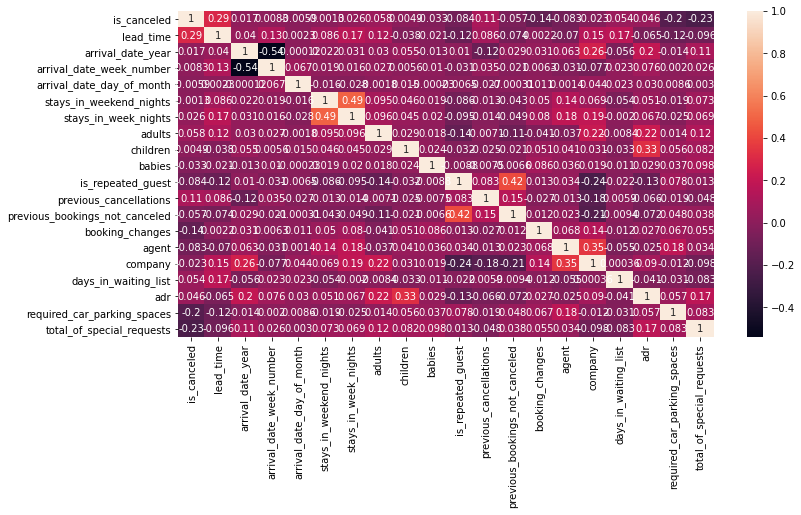

In [16]:
sns.heatmap(data.corr(), annot = True)

#### Since agent and company have large number of null values we are going to drop these columns

In [17]:
data.drop(columns = ["agent", "company"], axis = 1, inplace = True)

In [18]:
data.shape

(119210, 30)

In [19]:
data = data.dropna()

In [20]:
data.shape

(119210, 30)

#### Finding the most important features that affect cancellation

In [21]:
canceled_corr = data.corr()["is_canceled"]
canceled_corr.abs().sort_values(ascending = False)

is_canceled                       1.000000
lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

####  According to the above table, columns like stays in weekend nights, children, stays in week nights, total stay, month, year, day, babies, total guests do not affect the cancellation chances much.

In [22]:
drop_col_list = ["arrival_date_year","assigned_room_type", "days_in_waiting_list", "country"]
data.drop(columns = drop_col_list, axis = 1, inplace = True)

In [23]:
data.head(5)

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,July,27,1,0,0,2,0,...,0,C,3,No Deposit,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,July,27,1,0,0,2,0,...,0,C,4,No Deposit,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,July,27,1,0,1,1,0,...,0,A,0,No Deposit,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,July,27,1,0,1,1,0,...,0,A,0,No Deposit,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,July,27,1,0,2,2,0,...,0,A,0,No Deposit,Transient,98.0,0,1,Check-Out,2015-07-03


#### Segregating the categorical and numerical columns

In [24]:
categorical_list = [col for col in data.columns if df[col].dtype == "object"]

In [25]:
categorical_list

['hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [26]:
df_cat = data[categorical_list]

In [27]:
df_cat["reservation_status_date"] = pd.to_datetime(df_cat["reservation_status_date"])
df_cat["year"] = df_cat["reservation_status_date"].dt.year
df_cat["month"] = df_cat["reservation_status_date"].dt.month
df_cat["day"] = df_cat["reservation_status_date"].dt.day

In [28]:
# Dropping irrelevant categorical columns

cat_col_drop = ["arrival_date_month", "reservation_status_date", "reservation_status"]
df_cat.drop(columns = cat_col_drop, axis = 1, inplace = True)

In [29]:
df_cat.head(5)

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
1,Resort Hotel,BB,Direct,Direct,C,No Deposit,Transient,2015,7,1
2,Resort Hotel,BB,Direct,Direct,A,No Deposit,Transient,2015,7,2
3,Resort Hotel,BB,Corporate,Corporate,A,No Deposit,Transient,2015,7,2
4,Resort Hotel,BB,Online TA,TA/TO,A,No Deposit,Transient,2015,7,3


#### Encoding the categorical features using Label Encoder

In [30]:
le_list = []
for col in df_cat.columns:
    le = LabelEncoder()
    df_cat[col] = le.fit_transform(df_cat[col])
    le_list.append(le)

#### Function to get the label mappings of each column

In [31]:
def get_integer_mapping(le):
    # Returns label mappings for label encoder
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [32]:
df_cat.head(5)

,hotel,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,year,month,day
0,1,0,3,1,2,0,2,1,6,0
1,1,0,3,1,2,0,2,1,6,0
2,1,0,3,1,0,0,2,1,6,1
3,1,0,2,0,0,0,2,1,6,1
4,1,0,6,3,0,0,2,1,6,2


In [33]:
df_cat.shape

(119210, 10)

#### Getting the numerical features

In [34]:
df_num = data.drop(columns = categorical_list, axis = 1)

In [35]:
df_num.head(5)

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,27,1,0,0,2,0,0,0,0,0,3,0.0,0,0
1,0,737,27,1,0,0,2,0,0,0,0,0,4,0.0,0,0
2,0,7,27,1,0,1,1,0,0,0,0,0,0,75.0,0,0
3,0,13,27,1,0,1,1,0,0,0,0,0,0,75.0,0,0
4,0,14,27,1,0,2,2,0,0,0,0,0,0,98.0,0,1


In [36]:
df_num = df_num.drop(columns = ["is_canceled"], axis = 1)

#### Variance of numerical features

In [37]:
df_num.var()

lead_time                         11422.361808
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
stays_in_weekend_nights               0.990258
stays_in_week_nights                  3.599010
adults                                0.330838
children                              0.159070
babies                                0.009508
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
booking_changes                       0.407688
adr                                2543.589039
required_car_parking_spaces           0.060201
total_of_special_requests             0.628652
dtype: float64

#### Since the Average daily rate cannot be zero replacing it with the mean

In [38]:
df_num["adr"] = df_num["adr"].fillna(value = df_num["adr"].mean())

#### Normalizing the features 

In [39]:
scaler = MinMaxScaler()
num_df = df_num.copy()
num_df = pd.DataFrame(scaler.fit_transform(num_df), columns=list(df_num.columns), index = df_num.index)

In [40]:
num_df.var()

lead_time                         0.021029
arrival_date_week_number          0.068414
arrival_date_day_of_month         0.085675
stays_in_weekend_nights           0.002743
stays_in_week_nights              0.001440
adults                            0.000109
children                          0.001591
babies                            0.000095
is_repeated_guest                 0.030507
previous_cancellations            0.001056
previous_bookings_not_canceled    0.000433
booking_changes                   0.001258
adr                               0.000087
required_car_parking_spaces       0.000941
total_of_special_requests         0.025146
dtype: float64

In [41]:
num_df.shape

(119210, 15)

In [42]:
# df_cat = df_cat.reset_index()
# num_df = num_df.reset_index()

In [43]:
# num = df_num.copy()
# num["lead_time"] = np.log(num["lead_time"] + 1)
# num["adr"] = np.log(num["adr"] + 1)

In [44]:
# Combining the categorical and numerical columns

X = pd.concat([df_cat, num_df], axis = 1)

In [45]:
X.shape

(119210, 25)

In [46]:
y = data["is_canceled"]

In [47]:
# Splitting into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

# Logistic Regression

In [48]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {round(acc_lr,4)}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression is : 0.7904
Confusion Matrix : 
[[21547   971]
 [ 6524  6721]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     22518
           1       0.87      0.51      0.64     13245

    accuracy                           0.79     35763
   macro avg       0.82      0.73      0.75     35763
weighted avg       0.81      0.79      0.77     35763



#### Feature importance

In [49]:
feature_list = list(X.columns)
importance = list(lr.coef_[0])

In [50]:
feature_importance = pd.DataFrame()
feature_importance["Feature"] = feature_list
feature_importance["Importance"] = importance
feature_importance = feature_importance.sort_values(by = "Importance")

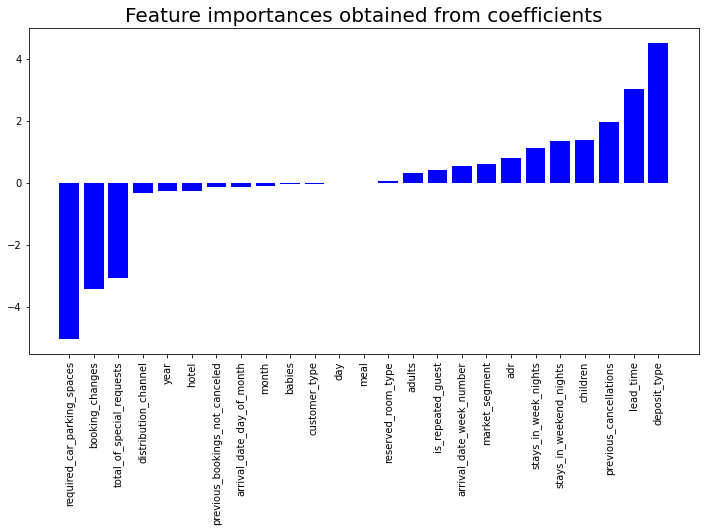

In [51]:
plt.bar(x = feature_importance["Feature"], height = feature_importance["Importance"], color='blue')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [52]:
model = ExtraTreesClassifier()
model.fit(X, y)
imp = model.feature_importances_

In [53]:
feature_importance["Tree_importance"] = imp

#  Random Forest Classifier

In [54]:
rf_model = RandomForestClassifier(min_samples_leaf=6, min_samples_split=6, n_estimators = 120)

In [55]:
rf_estimator = rf_model.fit(X_train, y_train)

In [56]:
y_pred_rf = rf_model.predict(X_test)

In [57]:
acc_rf = accuracy_score(y_test, y_pred_rf)
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
clf_report_rf = classification_report(y_test, y_pred_rf)

print(f"Accuracy Score of Random Forest is : {round(acc_rf,4)}")
print(f"Classification Report : \n{clf_report_rf}")

Accuracy Score of Random Forest is : 0.9309
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     22518
           1       0.98      0.83      0.90     13245

    accuracy                           0.93     35763
   macro avg       0.94      0.91      0.92     35763
weighted avg       0.93      0.93      0.93     35763



<AxesSubplot:>

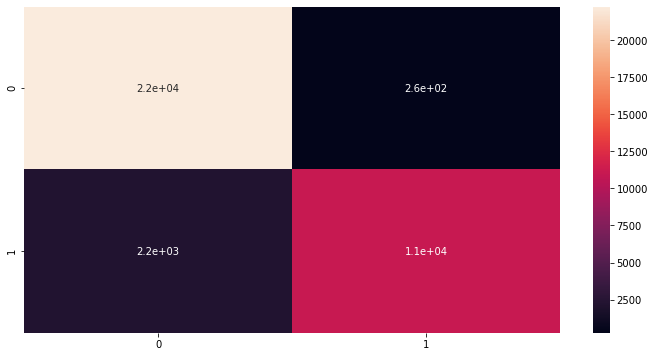

In [58]:
sns.heatmap(conf_mat_rf, annot = True)

# KNeighborsClassifier

In [59]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

In [60]:
acc_knn = accuracy_score(y_test, y_pred_knn)
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)
clf_report_knn = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNeighbors Classifier is : {round(acc_knn,4)}")
print(f"Classification Report : \n{clf_report_knn}")

Accuracy Score of KNeighbors Classifier is : 0.8595
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.95      0.89     22518
           1       0.89      0.71      0.79     13245

    accuracy                           0.86     35763
   macro avg       0.87      0.83      0.84     35763
weighted avg       0.86      0.86      0.86     35763



# Decision Tree Classifier

In [61]:
decision_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 30)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30)

In [62]:
y_pred_dtree = decision_tree.predict(X_test)
acc_dtree = accuracy_score(y_test, y_pred_dtree)
conf_mat_dtree = confusion_matrix(y_test, y_pred_dtree)
clf_report_dtree = classification_report(y_test, y_pred_dtree)

print(f"Accuracy Score of Decision Tree Classifier is : {round(acc_dtree,4)}")
print(f"Classification Report : \n{clf_report_dtree}")

Accuracy Score of Decision Tree Classifier is : 0.9531
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22518
           1       0.94      0.93      0.94     13245

    accuracy                           0.95     35763
   macro avg       0.95      0.95      0.95     35763
weighted avg       0.95      0.95      0.95     35763



#  Gradient Boosting Classifier

In [63]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
y_pred_gbclf = gb_clf.predict(X_test)

In [64]:
y_pred_gbclf = decision_tree.predict(X_test)
acc_gbclf = accuracy_score(y_test, y_pred_gbclf)
conf_mat_gbclf = confusion_matrix(y_test, y_pred_gbclf)
clf_report_gbclf = classification_report(y_test, y_pred_gbclf)

print(f"Accuracy Score of Gradient Boosting Classifier is : {round(acc_gbclf,4)}")
print(f"Classification Report : \n{clf_report_gbclf}")

Accuracy Score of Gradient Boosting Classifier is : 0.9531
Classification Report : 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22518
           1       0.94      0.93      0.94     13245

    accuracy                           0.95     35763
   macro avg       0.95      0.95      0.95     35763
weighted avg       0.95      0.95      0.95     35763



#  XGBoost Classifier

In [65]:
xgb = XGBClassifier(colsample_bytree = 0.6, alpha = 10, learning_rate = 0.1, max_depth = 8)
xgb.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [66]:
y_pred_xgb = xgb.predict(X_test)

In [67]:
acc_xgb = accuracy_score(y_test, y_pred_xgb)
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)
clf_report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Accuracy Score of Gradient Boosting Classifier is : {round(acc_xgb,4)}")
print(f"Classification Report : \n{clf_report_xgb}")

Accuracy Score of Gradient Boosting Classifier is : 0.9783
Classification Report : 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     22518
           1       1.00      0.94      0.97     13245

    accuracy                           0.98     35763
   macro avg       0.98      0.97      0.98     35763
weighted avg       0.98      0.98      0.98     35763

